# Recurrent Neural Networks for Text Classification

## Learning Objectives:
1. Understand how a recurrent neural network differs from a feed forward network
2. Learn to implement RNNs in Keras
3. Explore word embeddings for natural language processing
4. Use NLP to classify documents using word embeddings

What is a Recurrent Neural Network?

![RNN Image](https://www.researchgate.net/profile/Ali-Daud/publication/330920746/figure/fig2/AS:741304577318912@1553752192108/Folded-and-unfolded-regular-recurrent-neural-networks-with-single-hidden-recurrent-layer.png)

Source: https://www.researchgate.net/figure/Recurrent-neural-networks-structure_fig4_326884617

In a nutshell, an RNN takes in X<sub>t</sub> and outputs 2 things:  

1. y<sub>t</sub> The output.
2. W<sub>t</sub> a value that is passed back into the layer and combined with X<sub>t+1</sub> to produce:
  1. y<sub>t+t</sub>
  2. W<sub>t+1</sub>

...and so on until the end of the sequence of the input.

It is a recurring process that acts on each feature of an input **In Sequence**.

The W value allows the model to pass information from previous X<sub>t-1</sub> inputs to affect how the model processes the X<sub>t<sub> input.

You can think of this as a single node that is calling itself over and over (most accurate) or as a series of identical nodes being called in sequence (easier, but less accurate conceptualization).

The values passed to the next layer in the model could consist of all of the Y values or just the final output of node after processing all of the inputs.  This is a hyperparameter you can tune in your model development.  Y output sequences can also make up final model outputs where a full sequence is desired, not just a classification.  Translation models would be an example of this impelementation.  Forecasting a time series would be another.

There are many flavors of RNNs and what sets them apart is how the W is formed and what information is passed between recurrences.  

*Note* Just a like a densely connected layer, information is potentially passed through multiple of these recurring nodes in parallel for each layer in the model.

![multi-node RNN](https://gblobscdn.gitbook.com/assets%2F-LvBP1svpACTB1R1x_U4%2F-LwEQnQw8wHRB6_2zYtG%2F-LwEZT8zd07mLDuaQZwy%2Fimage.png?alt=media&token=93a3c3e2-e32b-4fec-baf5-5e6b092920c4)

Source: https://docs.paperspace.com/machine-learning/wiki/recurrent-neural-network-rnn

# Why RNNs?

While a feed forward network of dense layers processes each feature independently, an RNN treats them as a sequence in which the order of features is important.  This makes it ideal for:

1. Time series data
2. Audio data
3. Natural language
4. Anything else where the order of features carries important information.

# Memory Cells:

LSTMs, or Long-Short Term Memory RNNS and GRUs, Gated Recurrent Units, pass an additional value with the W, a memory cell.  While the W is fully dependent on the X and the previous W<sub>t-1</sub> values, the memory cell has potentially persistent values through multiple loops.  This allows the model have a more persistent memory of inputs from many steps previous to X<sub>t</sub>.  

For example, a GRU might learn to remember the tense of a sentence or the gender of a character.

![RNNs, LSTMs, and GRUs](https://slidetodoc.com/presentation_image_h/8a65d4524f55935cb441b783479395ed/image-33.jpg)

Source: https://slidetodoc.com/recurrent-neural-networks-deeplearning-ai-gated-recurrent-unit/

# What are the trainable Parameters:

The trainable parameters and activation functions in an RNN are the various weights and functions are inside each individual parallel node.  There are, potentially, more than one weight depending on the flavor of RNN.  However, the same weights are used for each feature in the sequence for a given node.

This is different than a dense node where each feature has a separate weight.  One potential benefit of this is that certain configurations of RNNs can process **variable** length inputs, which feed forward networks cannot.

#Further Reading

Here is a wonderful article by Michael Phi with animations that does a great job explaining further:  https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

# LSTMs in Keras

Keras has a pretty simple implementation of RNN layers.  Below I will demonstrate how to create an LSTM model.

In [122]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding, Dense, Dropout, InputLayer, LSTM, \
Flatten, GlobalMaxPool1D
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import Constant

from nltk.corpus import stopwords
from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

In [213]:
def confusion_plot(y_true, y_pred, labels=None):
  conf = confusion_matrix(y_true, y_pred, normalize='true')
  ax = sns.heatmap(conf, annot=True, xticklabels=labels, yticklabels=labels,
                   cmap="Greens" )
  return ax

In [124]:

def plot_history(history, title=None):
    """
    Given a model history will plot the model training history and 
    return the last scores for each loss and metric in the  model.
    Returns None.
    """
    hist = pd.DataFrame(history.history)
    fig = plt.figure(figsize = (10,5))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    loss = hist.columns[hist.columns.str.endswith('loss')]
    accuracy = hist.columns[hist.columns.str.endswith('accuracy')]
    hist[loss].plot(title='Loss', ax=ax)
    hist[accuracy].plot(title='accuracy', ax=ax2)
    plt.title(title)
    plt.show()
    
    for l in loss:
        print(f'final {l}: {hist[l].iloc[-1]}')
    for r in accuracy:
        print(f'final {r}: {hist[r].iloc[-1]}')
    plt.show()

## The Data:

We are going to return to our horror author data.  This is a collection of sentences from horror novels written by Edgar Allen Poe, H.P. Lovecraft, or Mary Shelley.  The task is to classify each sentency by the author who wrote it.

In [125]:
#load the data 
spooky = pd.read_csv('https://raw.githubusercontent.com/learn-co-students/011121-pt-ds/main/phase_4/nlp/horror_writers.csv', 
                     usecols=['text','author'])
spooky.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


In [126]:
X = spooky.text
y = spooky.author

#encode labels for multiclass classification in Keras
encoder = LabelEncoder()
y = encoder.fit_transform(y)
y = to_categorical(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=123)
X_val, X_holdout, y_val, y_holdout = train_test_split(X_test, y_test, test_size = .5, random_state=123)

## TextVectorization Layer

We are going to use a special Keras layer called TextVectorization that will process our input for us and transform into a sequences of integers to pass to our LSTM layer.  Layers like this can make models more like pipelines.  Notice that we only fit the vectorizer layer on the training set to avoid data leakage.

**NOTE** We can actually use Keras models in SKLearn pipelines and cross-validation functions by wrapping it in a KerasClassifier or KeraRegressor wrapper class.  [Here's some more information about that.](https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/)

There are several things to think about when configuring your `TextVectorization` layer.

1. In order to use the embedding layer (we will discuss this later) you need your vectorization layer to output just integer indices for the words.  Each word will be assigned an arbitrary integer that the embedding layer can reference later.  Do not use countvectors, binary, or TF-IDF.  We are not using a bag of words strategy.
2. It is not necessary to removing stop words  You might try both removing and leaving them in.  The layer is reading the text in sequence and may or may not benefit from syntactic words.
3. You do not need to lemmatize or stem your words.  Unlike bag of words approaches, you do want to keep the context of your tokens
4. You should, however lower the case and remove punctuation.  The embedding layer will be looking up the words in a table and doesn't need to attend to case or punctuation.  The token look ups are based on individual words and the difference between 'Horse' and 'horse' or 'horse.' and 'horse.' will not improve accuracy.

In [127]:
#max length of input.  
#Will truncate inputs longer and add 0s to the end of sequences that are longer.
output_sequence_length = spooky.text.str.len().max()

#define the length of the output sequences.  
#Here we are using the length of the longest sentence.  You can make it shorter.
vectorizer = TextVectorization(output_sequence_length=output_sequence_length,
                               #We want lists of integers as our output.
                               #These will be lookup indices in our embedding layer
                              output_mode='int',
                               #We will use the default standardization strategy
                               #We could also pass a custom function for custom
                               #standardization strategies.
                               standardize='lower_and_strip_punctuation')

#Fit the vectorizer to the training data.
#We need to transform it into a numpy array for this.
vectorizer.adapt(X_train.to_numpy())

#We will need the total length of the vocabulary for the embedding layer.
vocab_len = vectorizer.vocabulary_size()

In [128]:
def create_LSTM():
  model = Sequential()

  #Define your input layer for one feature (the whole string) and the dtype.
  #If you don't let Keras know to expect a string, it will assume it's looking
  #for a float and you'll get an error.
  model.add(InputLayer(input_shape=(1,), dtype=tf.string))

  #Fitted TextVectorization layer
  model.add(vectorizer)

  #Untrained Embedding Layer, embedding dimensions of 300
  #We'll talk about this layer more a little farther down
  model.add(Embedding(vocab_len, 300, input_length=output_sequence_length))
  
  #The recurrent LSTM layer.  We have it return all of its Y outputs for 
  #each cycle of each layer.
  model.add(LSTM(50, return_sequences=True, 
                #  dropout=0.5, 
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
  #The below below layer returns the highest activation of each LSTM node
  #for each input and pass them to the dense layer.
  model.add(GlobalMaxPool1D())
  
  model.add(Dense(50, activation='relu', 
                  kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))  
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='relu', 
                  kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))  
  model.add(Dropout(0.5))
  
  #Add an output layer.  3 nodes for 3 classes and a softmax activation
  model.add(Dense(3, activation='softmax'))

  optimizer = optimizers.Adam(learning_rate=.01)
  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 4663)              0         
_________________________________________________________________
embedding (Embedding)        (None, 4663, 300)         6284100   
_________________________________________________________________
lstm_1 (LSTM)                (None, 4663, 50)          70200     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)               

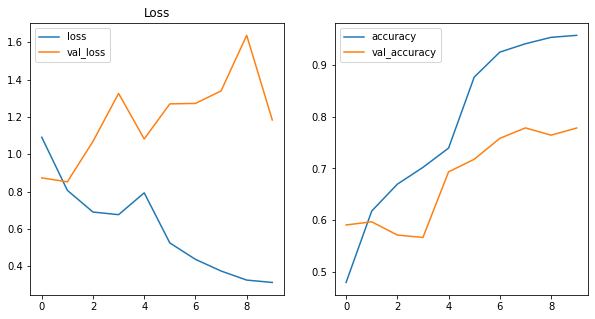

final loss: 0.3129194974899292
final val_loss: 1.1831005811691284
final accuracy: 0.9564995169639587
final val_accuracy: 0.7778345346450806
CPU times: user 9min 46s, sys: 17.3 s, total: 10min 3s
Wall time: 11min 5s


In [129]:
%%time
self_train = create_LSTM()

self_train.summary()

self_trained_history = self_train.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    batch_size = 128)

self_trained_score = self_train.evaluate(X_test, y_test)

print(f'Accraucy on Test Set {self_trained_score[1]}, Loss: {self_trained_score[0]}')
plot_history(self_trained_history)

# Word Embeddings

You have have noticed that we used tf.keras.layers.Embedding() after the text vectorization layer.  This is an amazingly awesome way of encoding words.  It transforms each word from an integer (from the vectorizer layer) to a vector.  What does it mean for a word to be a vector?

It means the representation of the word can contain arbitrary amounts of information about that word.  Each dimension of the space that the word vector exists in contains information about that word.

We can determine relationships between words and define similarity.

These embeddings are discovered using unsupervised learning on large datasets of text.  Several weights for embedding models are available that have been trained for thousands of hours on hundreds of millions of texts (All of wikipedia, or instance).  

The results are a library of {word:vector} pairs with each dimension of the vector representing a relationship between words learned from the corpus the model was trained on.

![Word embedding space](https://developers.google.com/machine-learning/crash-course/images/linear-relationships.svg)

Source: https://developers.google.com/machine-learning/crash-course/embeddings/translating-to-a-lower-dimensional-space


In [130]:
from sklearn.decomposition import PCA


import gensim.downloader as api
from gensim.test.utils import datapath
from gensim.models import KeyedVectors
word_vectors = api.load("glove-wiki-gigaword-100")

We can look up vectors like a dictionary

In [131]:
word_vectors['coffee']

array([ 0.12632  ,  0.86414  , -0.46052  ,  0.26095  ,  0.077033 ,
        0.076186 ,  0.71959  ,  0.38122  , -0.10287  , -0.44388  ,
       -0.52962  , -1.0485   , -0.0086082,  0.74915  , -0.15369  ,
        0.13386  ,  0.27879  , -0.46137  ,  0.24354  , -0.2938   ,
        0.018044 ,  0.63083  ,  0.7563   , -0.53305  , -0.087608 ,
        0.64316  ,  0.32683  , -0.80606  , -0.43119  , -0.20887  ,
        0.04233  ,  0.353    ,  0.88587  , -0.19565  ,  0.089291 ,
        1.2422   ,  0.30059  ,  0.11292  ,  0.58895  , -1.1495   ,
        0.04609  , -0.6724   ,  0.15442  , -1.0943   ,  0.6908   ,
        0.25969  , -1.0809   , -0.25303  ,  0.13122  , -1.3414   ,
       -0.39785  ,  0.041388 , -0.46881  ,  0.57462  , -0.40331  ,
       -0.98234  , -1.0115   ,  0.44262  ,  1.298    , -0.24297  ,
        0.10954  ,  0.35864  , -0.39146  , -0.68843  , -0.23691  ,
       -0.46501  ,  0.83416  , -0.61574  ,  1.2178   , -0.98078  ,
       -0.19633  ,  0.56886  ,  0.84273  ,  0.08674  , -0.3358

We can also use the gensim model to find relationships between words. For instance:

1. Similarity

In [132]:
word_vectors.most_similar('coffee')

[('tea', 0.77326899766922),
 ('drinks', 0.7287518978118896),
 ('beer', 0.7253385782241821),
 ('cocoa', 0.7026591300964355),
 ('wine', 0.7002726793289185),
 ('drink', 0.699092447757721),
 ('corn', 0.6825441122055054),
 ('sugar', 0.6775093078613281),
 ('bread', 0.6727856397628784),
 ('fruit', 0.6671490669250488)]

2. Analogies

In [133]:
def analogy(x1, x2, y1):
    result = word_vectors.most_similar(positive=[y1, x2], negative=[x1])
    return result

In [134]:
analogy('japan','japanese','america')

[('american', 0.8103364706039429),
 ('americans', 0.6751643419265747),
 ('latin', 0.6664613485336304),
 ('black', 0.634178102016449),
 ('many', 0.6329406499862671),
 ('``', 0.6276753544807434),
 ('mexican', 0.6221809983253479),
 ('nation', 0.6197335720062256),
 ('among', 0.6174299716949463),
 ('even', 0.6061267852783203)]

In [135]:
analogy('man','king','woman')

[('queen', 0.7698541283607483),
 ('monarch', 0.6843380928039551),
 ('throne', 0.6755735874176025),
 ('daughter', 0.6594556570053101),
 ('princess', 0.6520534753799438),
 ('prince', 0.6517034769058228),
 ('elizabeth', 0.6464517712593079),
 ('mother', 0.6311717629432678),
 ('emperor', 0.6106470823287964),
 ('wife', 0.6098655462265015)]

# Bias in Word Embeddings
These relationships are learned from texts from the real world and carry the associations present in them.  We need to be aware of introducing bias into models that may affect people's lives.

In [136]:
analogy('man','doctor','woman')

[('nurse', 0.7735227346420288),
 ('physician', 0.7189429998397827),
 ('doctors', 0.6824328303337097),
 ('patient', 0.6750682592391968),
 ('dentist', 0.6726033687591553),
 ('pregnant', 0.6642460227012634),
 ('medical', 0.6520450115203857),
 ('nursing', 0.645348072052002),
 ('mother', 0.6393327116966248),
 ('hospital', 0.6387495994567871)]

## Graphical Representation

In [137]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]
        
    word_vectors = np.array([model[w] for w in words])

    twodim = PCA().fit_transform(word_vectors)[:,:2]
    
    plt.figure(figsize=(6,6))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)

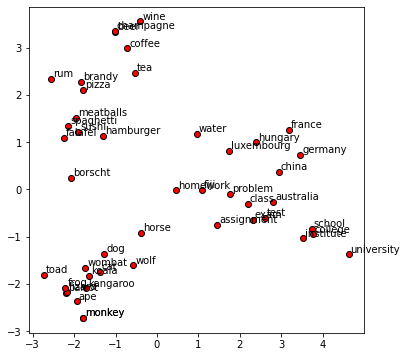

In [138]:
display_pca_scatterplot(word_vectors, 
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

# SpaCy

Gensim is great because it lets us easily explore word embeddings.  SpaCy is great because it loads word embeddings much faster, allowing us to use larger embedding models, and has some great functionality for NLP, including parts of speech, processing, and more.

In [139]:
import spacy

# download and import the large english model.
!python -m spacy download en_core_web_lg
import en_core_web_lg
# nlp will be our word embedding model
nlp = en_core_web_lg.load()


     |████████████████████████████████| 827.9 MB 1.2 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')


In our last model, we allowed our embedding layer to learn its own embedding vectors from the texts in our training corpus.  But what if we used transfer learning to instead load the weights from a pretrained word embedding model?

# Creating Word Embedding Weights

We have to create our own matrix of weights for our embedding layer.  We do this by using our vectorizer to create an index for a matrix, and filling in each row of the matrix with the word embedding provided by our pretrained word embedding model.  The result is a (vocab, embedding_dimension) shaped numpy array that our LSTM layer can use as a lookup table to find the correct embedding for each word in our text samples.

Finally, we freeze those weights to reduce computation time.

## LSTM
As you recall, each node of the LSTM layer processes each word in each document in order, using the word embedding from the Embedding layer as the value for that word.  LSTMs 'remember' information from previous items in the sequence, words in the sentence in this case, and carry that information forward to help process later items in the sequence.


In [140]:

#generate the embedding matrix
vocab = vectorizer.get_vocabulary()
num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector)

#Generate the embedding weights usign the SpaCy word vectors for the vocabulary
#in our training corpus.  (This may take awhile)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

In [141]:
def create_pretrain_LSTM():
  model = Sequential()

  #Define your input layer for one feature (the whole string) and the dtype.
  #If you don't let Keras know to expect a string, it will assume it's looking
  #for a float and you'll get an error.
  model.add(InputLayer(input_shape=(1,), dtype=tf.string))

  #Fitted TextVectorization layer
  model.add(vectorizer)

  #Untrained Embedding Layer, embedding dimensions of 300
  #We'll talk about this layer more a little farther down
  model.add(Embedding_layer)
  
  #The recurrent LSTM layer.  We have it return all of its Y outputs for 
  #each cycle of each layer.
  model.add(LSTM(50, return_sequences=True,
                #  dropout=0.5,
                 kernel_regularizer=regularizers.l1_l2(l1=1e-4, l2=1e-3)))
  #The below below layer returns the highest activation of each LSTM node
  #for each input and pass them to the dense layer.
  model.add(GlobalMaxPool1D())
  
  model.add(Dense(50, activation='relu', 
                  kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))  
  model.add(Dropout(0.5))
  
  model.add(Dense(50, activation='relu', 
                  kernel_regularizer = regularizers.l1_l2(l1=1e-4, l2=1e-3)))  
  model.add(Dropout(0.5))
  
  #Add an output layer.  3 nodes for 3 classes and a softmax activation
  model.add(Dense(3, activation='softmax'))

  optimizer = optimizers.Adam(learning_rate=.01)
  model.compile(loss = 'categorical_crossentropy', optimizer = optimizer, metrics = ['accuracy'])

  return model

In [142]:
%%time

#Delete previously drawn tensorflow graphs from memory. Helps with memory management
tf.keras.backend.clear_session()

pretrain = create_pretrain_LSTM()

pretrain.summary()

pretrained_history = pretrain.fit(X_train,
                    y_train,
                    validation_data = (X_val, y_val),
                    epochs = 10,
                    batch_size = 128)

pretrained_score = pretrain.evaluate(X_test, y_test)



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, 4663)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 4663, 300)         6284100   
_________________________________________________________________
lstm (LSTM)                  (None, 4663, 50)          70200     
_________________________________________________________________
global_max_pooling1d (Global (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2

Accuracy of Self-trained Embedding model: 0.779366672039032, Loss: 1.2007979154586792


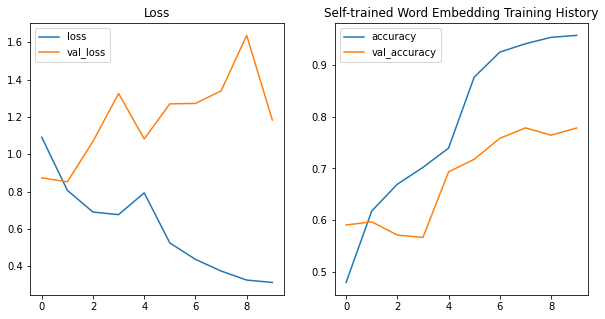

final loss: 0.3129194974899292
final val_loss: 1.1831005811691284
final accuracy: 0.9564995169639587
final val_accuracy: 0.7778345346450806
Accuracy of Pretrained Embedding model: 0.7528089880943298, Loss: 0.8265091776847839


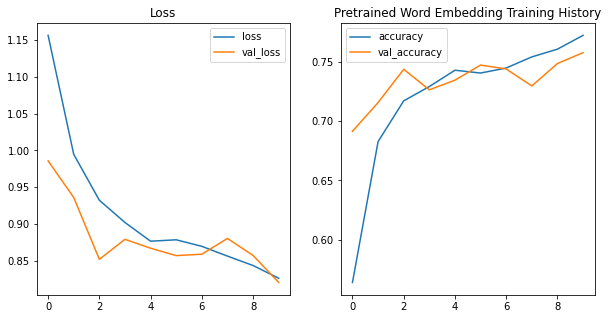

final loss: 0.8262230753898621
final val_loss: 0.8204911351203918
final accuracy: 0.7725376486778259
final val_accuracy: 0.7579162120819092


In [143]:
print(f'Accuracy of Self-trained Embedding model: {self_trained_score[1]}, Loss: {self_trained_score[0]}')
plot_history(self_trained_history, title='Self-trained Word Embedding Training History')
print(f'Accuracy of Pretrained Embedding model: {pretrained_score[1]}, Loss: {pretrained_score[0]}')
plot_history(pretrained_history, title='Pretrained Word Embedding Training History')


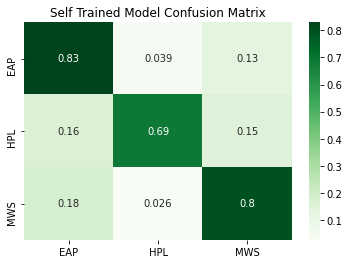

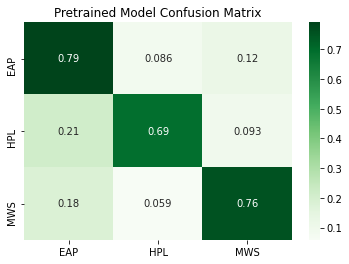

In [203]:
# self_train_pred = np.argmax(self_train.predict(X_test), axis=1)
# pretrain_pred = np.argmax(pretrain.predict(X_test), axis=1)
# y_test1d = np.argmax(y_test, axis=1)

ax1 = confusion_plot(y_test1d, self_train_pred, labels=encoder.classes_)
ax1.set_title('Self Trained Model Confusion Matrix')
plt.show()
ax2 = confusion_plot(y_test1d, pretrain_pred, labels=encoder.classes_)
ax2.set_title('Pretrained Model Confusion Matrix')
plt.show()

## Final Model Evaluation:
Which model should we choose as our best?

In [146]:
#best_model = 
#final_scores = model.evaluation(X_holdout, y_holdout)

# Conclusion

In this lesson you learned about recurrent neural networks, or RNNs, how to implement them in Keras, and how to use transfer learning to improve a natural language processing modeling task.

I hope you feel comfortable and confident to use these powerful tools in your own work.

# References:

[Pretrained Word Embeddings using SpaCy and Keras TextVectorization](https://towardsdatascience.com/pretrained-word-embeddings-using-spacy-and-keras-textvectorization-ef75ecd56360)

[Multi-Class Text Classification with LSTM](https://towardsdatascience.com/multi-class-text-classification-with-lstm-1590bee1bd17)